In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

%cd /content/drive/MyDrive/Colab\ Notebooks/GitHub/

# Set current working project repo
repository = 'AmazonReview_UsefulnessRanker'
%cd {repository}

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/GitHub
/content/drive/MyDrive/Colab Notebooks/GitHub/AmazonReview_UsefulnessRanker


In [2]:
# Checking available GPU

# import tensorflow as tf
# print("GPU Available:", tf.config.list_physical_devices('GPU'))

#**Problem Statement:**

## Overview

## Instructions
The Amazon Book Reviews Dataset is a collection of customer reviews for books sold on Amazon. This dataset is part of the broader Amazon Customer Reviews Dataset, which includes reviews for a variety of product categories.The Book dataset offers insights into customer opinions, ratings, and experiences with books, making it a valuable resource for research in natural language processing (NLP), sentiment analysis, and recommendation systems.

## Data:
* Download the Amazon Book Reviews Dataset from [Kaggle](https://www.kaggle.com/datasets/cynthiarempel/amazon-us-customer-reviews-dataset?select=amazon_reviews_us_Books_v1_02.tsv).
* Note: you do not need to download the full dataset - just the books subset:
* Filter the dataset for the last two years of reviews available (2003-2005).

### Data Dictionary:
* **marketplace:** A two-letter country code representing the marketplace where the review was written.
* **customer_id:** A random identifier for the customer.
* **review_id:** The unique identifier for each review.
* **product_id:** The unique identifier for the product being reviewed.
* **product_parent:** A random identifier that can be used to aggregate reviews for the same product.
* **product_title:** The title of the product.
* **product_category:** The broad category under which the product falls.
* **star_rating:** The star rating given by the reviewer, ranging from 1 to 5 stars.
* **helpful_votes:** The number of votes indicating how many customers found
the review helpful.
* **total_votes:** The total number of votes the review received.
* **vine:** Indicates whether the review was written as part of the Vine program, where selected reviewers receive free products for review.
* **verified_purchase:** Indicates whether the review is based on a verified purchase.
* **review_headline:** The title or headline of the review.
* **review_body:** The main text of the review.
* **review_date:** The date on which the review was written.

## Background to Task
* You are responsible for optimising the display of information on an e-commerce website selling books.
* This website contains descriptions of books and a section on each book page for users to leave reviews of books they have previously read. You have been asked to create a model that will optimise the display of reviews so that reviews which are most likely to be helpful are surfaced first to users while reviews that are less likely to be helpful are less likely to be displayed.

## Outline of Objectives
* Carry out EDA of the dataset and report on your findings - this may be inline in a notebook based tool

* Create a model that predicts the likelihood of a review being helpful (you may, for example, take the ‘helpfulness’ as the ratio of helpful_votes to total_votes)

* Evaluate this model and report on your findings

In [3]:
# Install required libraries

# !pip install sentence-transformers
# !pip install joblib

In [4]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Regular expressions
import re

# File handling and compression
import os
import zipfile
import joblib
from joblib import dump, load

# Progress bar
from tqdm import tqdm

# Multiprocessing
from multiprocessing import Pool, cpu_count

# Plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Natural Language Processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk import pos_tag

# Download necessary NLTK data files (commented out, only needed for first run)
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')

# Feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Model building
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
import xgboost as xgb
import lightgbm as lgb

# Model evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error

# Metrics
from sklearn.metrics import r2_score, mean_absolute_error, explained_variance_score, mean_squared_error

# Pipeline
# from imblearn.pipeline import Pipeline

# Handling large data and memory management
import gc
import pickle
import scipy.sparse
from scipy.sparse import vstack

# Suppress all warnings
import warnings
warnings.filterwarnings('ignore')

# Uncomment if using Torch and Sentence Transformers
# import torch
# from torch.cuda.amp import autocast
# from sentence_transformers import SentenceTransformer

## Load Data

### **Filtering data**

In [5]:
# Setting random seed
seed = 42
np.random.seed(seed)

In [6]:
# Loading the filtered data
def load_and_filter_data(zip_file_path, tsv_filename, parquet_file_path, start_date, end_date):
    """
    Load data from a zip file, filter by date range, and save to a parquet file.

    Args:
        zip_file_path (str): Path to the zip file.
        tsv_filename (str): Name of the TSV file within the zip archive.
        parquet_file_path (str): Path to save the filtered parquet file.
        start_date (str): Start date for filtering in 'YYYY-MM-DD' format.
        end_date (str): End date for filtering in 'YYYY-MM-DD' format.

    Returns:
        pd.DataFrame: Filtered DataFrame.
    """
    # Convert start and end dates to datetime
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # Check if the filtered data file already exists
    if os.path.exists(parquet_file_path):
        print(f"Loading data from {parquet_file_path}...")
        book_df = pd.read_parquet(parquet_file_path)
    else:
        print(f"Loading data from {zip_file_path} and filtering by date range...")
        with zipfile.ZipFile(zip_file_path, 'r') as z:
            with z.open(tsv_filename) as f:
                df = pd.read_csv(f, sep='\t', on_bad_lines='skip')

        # Convert 'review_date' to datetime format
        df['review_date'] = pd.to_datetime(df['review_date'])

        # Apply the date filter
        book_df = df.loc[(df['review_date'] >= start_date) & (df['review_date'] <= end_date), :].copy()

        # Optionally, reset the index
        book_df.reset_index(drop=True, inplace=True)

        # Save the filtered DataFrame to a parquet file
        book_df.to_parquet(parquet_file_path, index=False)

    return book_df

# Define the paths and date range
zip_file_path = r"/content/drive/MyDrive/Colab Notebooks/GitHub/AmazonReview_UsefulnessRanker/data/amazon_reviews_us_Books_v1_02.tsv.zip"
tsv_filename = 'amazon_reviews_us_Books_v1_02.tsv'
parquet_file_path = r"/content/drive/MyDrive/Colab Notebooks/GitHub/AmazonReview_UsefulnessRanker/data/filtered_amazon_reviews.parquet"
start_date = '2003-01-01'
end_date = '2005-12-31'

# Load and filter the data
book_df = load_and_filter_data(zip_file_path, tsv_filename, parquet_file_path, start_date, end_date)

# Display the first few rows of the DataFrame
print(book_df.shape)
print(book_df.info())
book_df.head()

Loading data from /content/drive/MyDrive/Colab Notebooks/GitHub/AmazonReview_UsefulnessRanker/data/filtered_amazon_reviews.parquet...
(1286157, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1286157 entries, 0 to 1286156
Data columns (total 15 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   marketplace        1286157 non-null  object 
 1   customer_id        1286157 non-null  int64  
 2   review_id          1286157 non-null  object 
 3   product_id         1286157 non-null  object 
 4   product_parent     1286157 non-null  int64  
 5   product_title      1286157 non-null  object 
 6   product_category   1286157 non-null  object 
 7   star_rating        1286157 non-null  float64
 8   helpful_votes      1286157 non-null  float64
 9   total_votes        1286157 non-null  float64
 10  vine               1286157 non-null  object 
 11  verified_purchase  1286157 non-null  object 
 12  review_headline    1286122 non-nul

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,12076615,RQ58W7SMO911M,0385730586,122662979,Sisterhood of the Traveling Pants (Book 1),Books,4.0,2.0,3.0,N,N,this book was a great learning novel!,this boook was a great one that you could lear...,2005-10-14
1,US,12703090,RF6IUKMGL8SF,0811828964,56191234,The Bad Girl's Guide to Getting What You Want,Books,3.0,5.0,5.0,N,N,Fun Fluff,If you are looking for something to stimulate ...,2005-10-14
2,US,12257412,R1DOSHH6AI622S,1844161560,253182049,"Eisenhorn (A Warhammer 40,000 Omnibus)",Books,4.0,1.0,22.0,N,N,this isn't a review,never read it-a young relative idicated he lik...,2005-10-14
3,US,50732546,RATOTLA3OF70O,0373836635,348672532,Colby Conspiracy (Colby Agency),Books,5.0,2.0,2.0,N,N,fine author on her A-game,Though she is honored to be Chicago Woman of t...,2005-10-14
4,US,51964897,R1TNWRKIVHVYOV,0262181533,598678717,The Psychology of Proof: Deductive Reasoning i...,Books,4.0,0.0,2.0,N,N,Execellent cursor examination,Review based on a cursory examination by Unive...,2005-10-14


### **Target Variable Creation**

In [7]:
# Missing value Treatment
book_df.isnull().sum()

marketplace           0
customer_id           0
review_id             0
product_id            0
product_parent        0
product_title         0
product_category      0
star_rating           0
helpful_votes         0
total_votes           0
vine                  0
verified_purchase     0
review_headline      35
review_body           0
review_date           0
dtype: int64

In [8]:
book_df.review_headline.fillna('', inplace=True)

In [9]:
# Check for zero or negative values in 'total_votes' and 'helpful_votes'
zero_total_votes = (book_df['total_votes'] == 0).sum()
negative_helpful_votes = (book_df['helpful_votes'] < 0).sum()

print(f"Total zero values in total_votes: {zero_total_votes}")
print(f"Total negative values in helpful_votes: {negative_helpful_votes}")

# Filter out rows where total_votes is zero or negative helpful_votes
book_df = book_df[(book_df['total_votes'] > 0) & (book_df['helpful_votes'] >= 0)].copy()

# Calculate helpfulness ratio
book_df['helpfulness_ratio'] = book_df['helpful_votes'] / book_df['total_votes']

Total zero values in total_votes: 111288
Total negative values in helpful_votes: 0


Descriptive Statistics of Helpfulness Ratio:
count    1174869.000
mean           0.741
std            0.290
min            0.000
25%            0.562
50%            0.833
75%            1.000
max            1.000
Name: helpfulness_ratio, dtype: float64


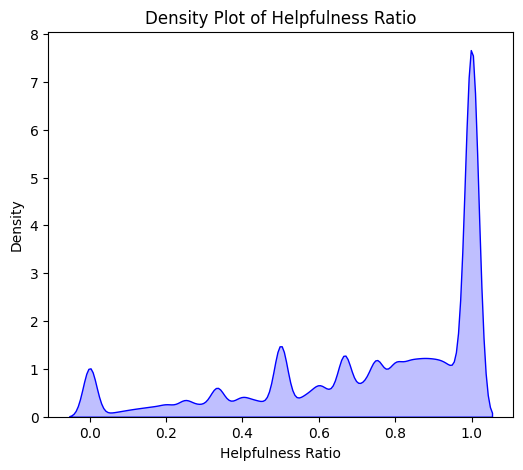

In [10]:
# Compute descriptive statistics
stats = book_df['helpfulness_ratio'].describe()

# Format the statistics
formatted_stats = stats.apply(lambda x: round(x, 3))  # Round to 3 decimal places

# Print formatted statistics
print("Descriptive Statistics of Helpfulness Ratio:")
print(formatted_stats)

# Kernel Density Plot
plt.figure(figsize=(6, 5))
sns.kdeplot(book_df['helpfulness_ratio'], fill=True, color='blue')
plt.title('Density Plot of Helpfulness Ratio')
plt.xlabel('Helpfulness Ratio')
plt.ylabel('Density')
plt.show()

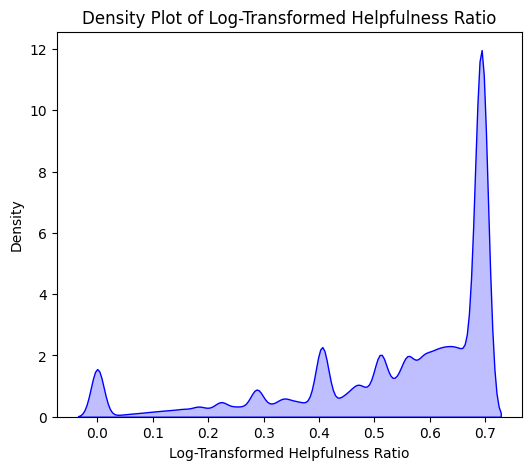

Descriptive Statistics of Helpfulness Ratio:
count    1174869.000
mean           0.538
std            0.189
min            0.000
25%            0.446
50%            0.606
75%            0.693
max            0.693
Name: log_helpfulness_ratio, dtype: float64


In [11]:
# Apply log transformation (log1p) to handle skewness
book_df['log_helpfulness_ratio'] = np.log1p(book_df['helpfulness_ratio'])

# Drop the original helpfulness_ratio column
book_df.drop(columns=['helpfulness_ratio'], inplace=True)

# Compute descriptive statistics
stats = book_df['log_helpfulness_ratio'].describe()

# Kernel Density Plot of log_helpfulness_ratio
plt.figure(figsize=(6, 5))
sns.kdeplot(book_df['log_helpfulness_ratio'], fill=True, color='blue')
plt.title('Density Plot of Log-Transformed Helpfulness Ratio')
plt.xlabel('Log-Transformed Helpfulness Ratio')
plt.ylabel('Density')
plt.show()

# Compute descriptive statistics
stats = book_df['log_helpfulness_ratio'].describe()

# Format the statistics
formatted_stats = stats.apply(lambda x: round(x, 3))  # Round to 3 decimal places

# Print formatted statistics
print("Descriptive Statistics of Helpfulness Ratio:")
print(formatted_stats)

In [12]:
# Recheck of missing values
print("Checking for NaN values:")
print(book_df.isnull().sum())

Checking for NaN values:
marketplace              0
customer_id              0
review_id                0
product_id               0
product_parent           0
product_title            0
product_category         0
star_rating              0
helpful_votes            0
total_votes              0
vine                     0
verified_purchase        0
review_headline          0
review_body              0
review_date              0
log_helpfulness_ratio    0
dtype: int64


**Observation:**

- **Data:**
  - The Book review dataframe contains **1,286,157** entries and **15** columns. This may require efficient processing techniques for memory optimization.
  - Dataset has a mix of data types with customer info, product info, customer reviews, star rating and votes ranging from int, float and text data.
  - The data doesn't have any significant missing values except for review headline. However, we decide to impute this rather than drop the rows as we want to concatenate review headline and review body.
  - Potential issues include zero values in 'total_votes'. Since this is crucial for calculating the 'helpfulness_ratio', any zero values in this column should be filtered out to avoid division by zero errors.
  - The 'star_rating' and understanding it's distribution could provide insights into customer satisfaction but our main focus is on review usefulness. Will not focus on this column.
  - The 'Review data' includign the date is used to filter the last 2 year reviews. This helps us focus on the most recent review which may have better impact on the usefulness of the review.
  - The filtered dataframe has a memory usage of **147.2+ MB**, which is manageable but could grow significantly with additional processing.
- **Target Variable:**
  - Issue: Noticed slight right-skewness in the distribution of helpfulness ratio. Which implies higher helpfulness ratios than lower ones, but this is expected considering the nature of how users see only few reviews.
  * **Proposed:** Applying log transformation to reduce the skewness slightly   

## Data Preprocessing

### **EDA**

In [13]:
# Optimizing memory usage of book dataframe
def optimize_memory_usage(df):
    """
    Optimizes the memory usage of a pandas DataFrame by converting data types appropriately.

    Args:
        df (pd.DataFrame): The original DataFrame to be optimized.

    Returns:
        pd.DataFrame: The optimized DataFrame.
    """
    # Drop unnecessary columns
    cols_drop = ['marketplace', 'customer_id', 'review_id', 'product_category',
                 'product_parent', 'vine', 'verified_purchase', 'helpful_votes', 'total_votes']
    cols_to_drop = [col for col in cols_drop if col in df.columns]
    df = df.drop(cols_to_drop, axis=1).reset_index(drop=True)

    # Initial memory usage
    print("Initial memory usage:")
    print(df.memory_usage(deep=True))

    # Convert object types to category
    for col in ['product_id', 'verified_purchase']:
        if col in df.columns:
            df[col] = df[col].astype('category')

    # Convert numeric types
    if 'star_rating' in df.columns:
        df['star_rating'] = df['star_rating'].astype('float32')

    # Convert review_date to datetime
    if 'review_date' in df.columns:
        df['review_date'] = pd.to_datetime(df['review_date'])

    # Convert log_helpfulness_ratio to float32
    if 'log_helpfulness_ratio' in df.columns:
        df['log_helpfulness_ratio'] = df['log_helpfulness_ratio'].astype('float32')

    # For textual data, check unique values and decide if converting to category is beneficial
    if 'review_headline' in df.columns and df['review_headline'].nunique() / len(df) < 0.5:
        df['review_headline'] = df['review_headline'].astype('category')
    if 'review_body' in df.columns and df['review_body'].nunique() / len(df) < 0.5:
        df['review_body'] = df['review_body'].astype('category')

    # Optimized memory usage
    print("Optimized memory usage:")
    print(df.memory_usage(deep=True))

    return df

# Optimize memory usage
book_df = optimize_memory_usage(book_df)

Initial memory usage:
Index                           128
product_id                 78716223
product_title             121660990
star_rating                 9398952
review_headline           101051759
review_body              1314263212
review_date                78716223
log_helpfulness_ratio       9398952
dtype: int64
Optimized memory usage:
Index                           128
product_id                 38501502
product_title             121660990
star_rating                 4699476
review_headline           101132970
review_body              1333735953
review_date                 9398952
log_helpfulness_ratio       4699476
dtype: int64


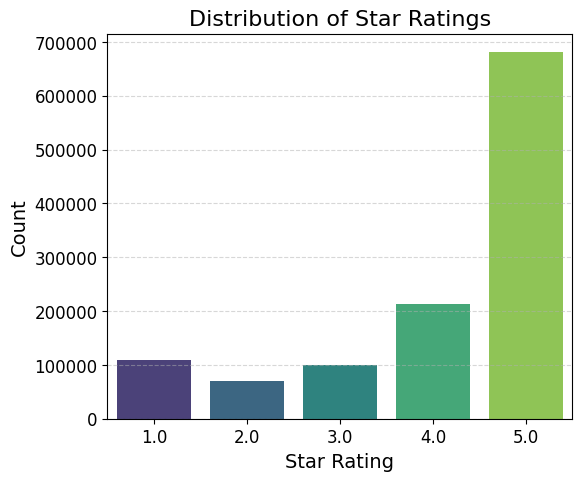

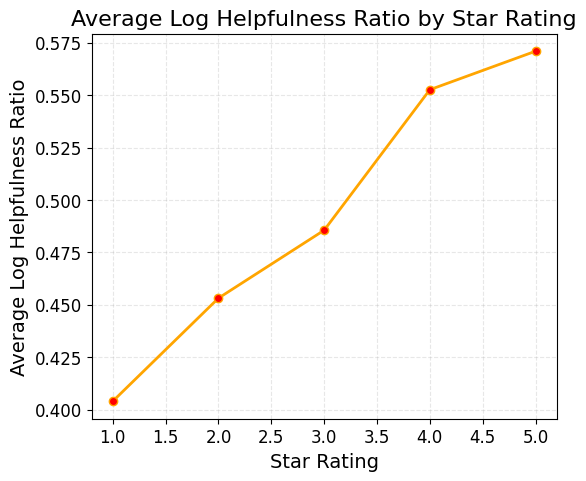

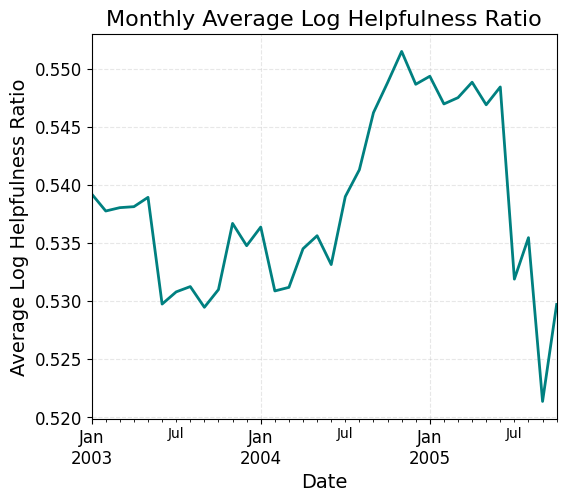

In [14]:
plt.figure(figsize=(6, 5))
sns.countplot(x='star_rating', data=book_df, palette='viridis')
plt.title('Distribution of Star Ratings', fontsize=16)
plt.xlabel('Star Rating', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

avg_helpfulness_by_star = book_df.groupby('star_rating')['log_helpfulness_ratio'].mean()

plt.figure(figsize=(6, 5))
avg_helpfulness_by_star.plot(kind='line', marker='o', color='orange', linewidth=2, markerfacecolor='red')
plt.title('Average Log Helpfulness Ratio by Star Rating', fontsize=16)
plt.xlabel('Star Rating', fontsize=14)
plt.ylabel('Average Log Helpfulness Ratio', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(linestyle='--', alpha=0.3)
plt.show()

book_df['review_date'] = pd.to_datetime(book_df['review_date'])
monthly_helpfulness = book_df.set_index('review_date').resample('M')['log_helpfulness_ratio'].mean()

plt.figure(figsize=(6, 5))
monthly_helpfulness.plot(color='teal', linewidth=2)
plt.title('Monthly Average Log Helpfulness Ratio', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Average Log Helpfulness Ratio', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(linestyle='--', alpha=0.3)
plt.show()


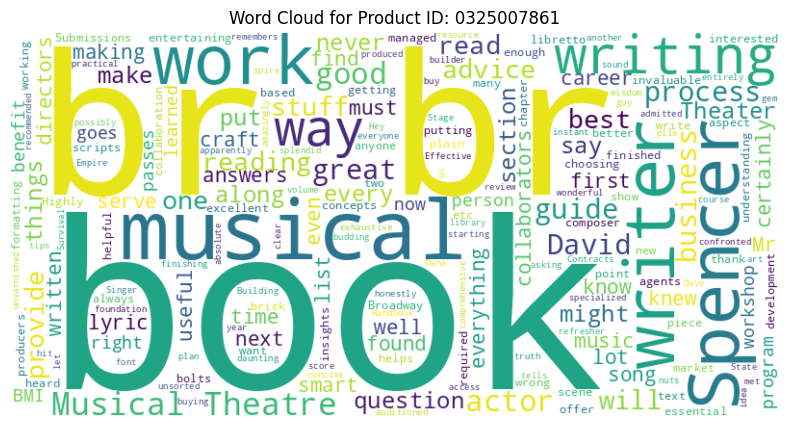

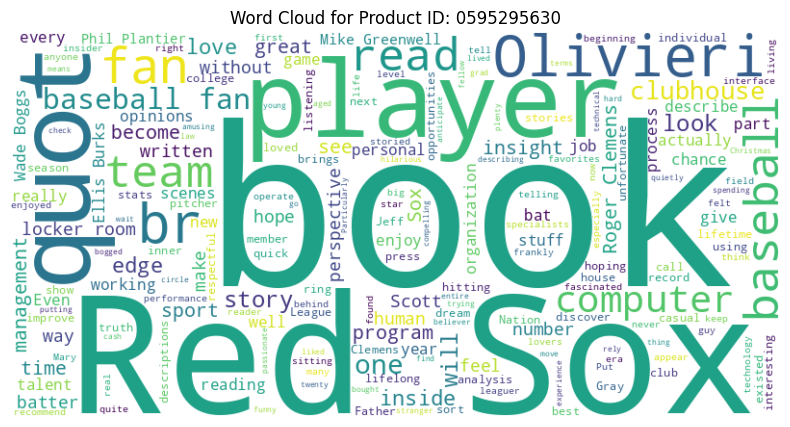

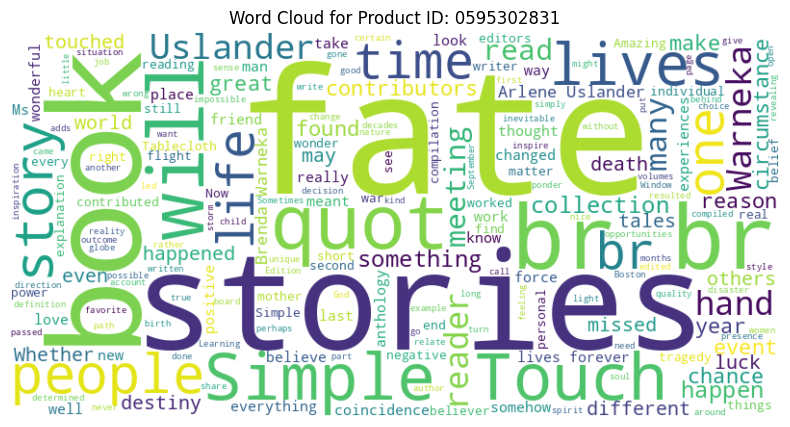

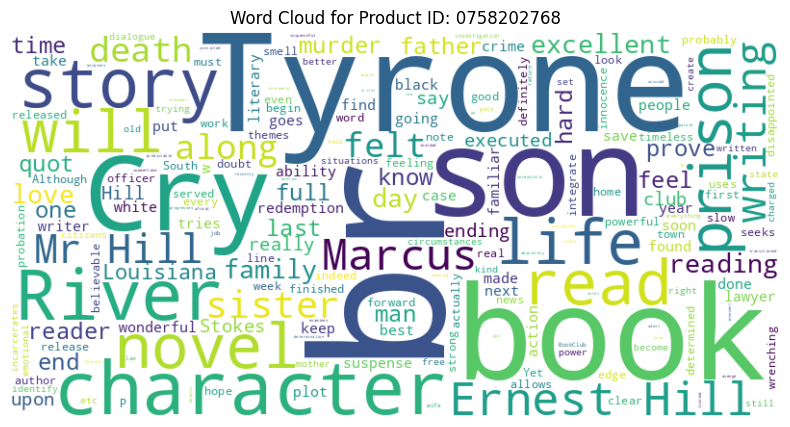

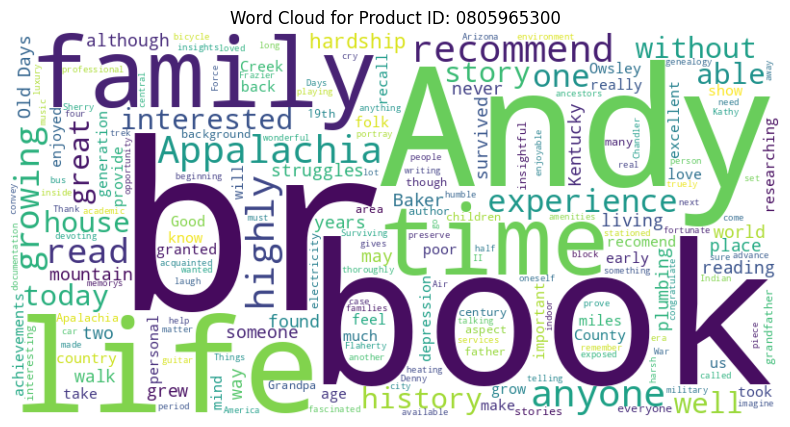

In [15]:
# Looking at word cloud of top product reviews
top_products = book_df.groupby('product_id')['log_helpfulness_ratio'].mean().nlargest(5).index
top_reviews = book_df[book_df['product_id'].isin(top_products)]

# Function to create a word cloud for a specific product
def plot_word_cloud(product_id):
    product_reviews = ' '.join(top_reviews[top_reviews['product_id'] == product_id]['review_body'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(product_reviews)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Product ID: {product_id}')
    plt.show()

# Generate word clouds for the top products
for product in top_products:
    plot_word_cloud(product)

**Observation:**
- Based on the star ratings, majority of ratings cluster around 4 or 5 stars, it suggests that customers generally find the books appealing.
- The average log helpfulness ratio by star rating usually suggest that higher-rated books tend to receive more helpful feedback from reader, highlighting a correlation between quality and perceived usefulenss of reviews.
- Monthly average log helpfulness ratio time series plot depicts the log helpfulness over time. There are fluctuations around 2005 which may have been in correlation with book releases or promotional events, also suggests increased engagement from readers during those periods.

### **Truncate reviews**

In [16]:
# Check Unique values
book_df.nunique()

product_id                378326
product_title             355072
star_rating                    5
review_headline           967821
review_body              1167335
review_date                 1018
log_helpfulness_ratio       9219
dtype: int64

In [17]:
def split_dataframes(df):
    """
    Splits the DataFrame into metadata and review DataFrames.

    Args:
        df (pd.DataFrame): The original DataFrame to be split.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: The metadata DataFrame and the review DataFrame.
    """
    # Extract metadata columns
    metadata_df = df[['product_id', 'product_title',
                      'star_rating', 'review_date']].copy()

    # Extract columns for analysis
    review_df = df[['product_id', 'review_headline', 'review_body',
                    'log_helpfulness_ratio']].copy()

    # Optionally, reset the index for both DataFrames if needed
    metadata_df.reset_index(drop=True, inplace=True)
    review_df.reset_index(drop=True, inplace=True)

    return metadata_df, review_df

# Split into metadata and review DataFrames
metadata_df, review_df = split_dataframes(book_df)

# Free up memory
del book_df

# print("Metadata DataFrame:")
# print(metadata_df.head())

# Display first few rows of each DataFrame to verify
print("\nReview DataFrame:")
review_df.head()


Review DataFrame:


,product_id,review_headline,review_body,log_helpfulness_ratio
0,0385730586,this book was a great learning novel!,this boook was a great one that you could lear...,0.510826
1,0811828964,Fun Fluff,If you are looking for something to stimulate ...,0.693147
2,1844161560,this isn't a review,never read it-a young relative idicated he lik...,0.044452
3,0373836635,fine author on her A-game,Though she is honored to be Chicago Woman of t...,0.693147
4,0262181533,Execellent cursor examination,Review based on a cursory examination by Unive...,0.000000


In [18]:
metadata_df.nunique()

product_id       378326
product_title    355072
star_rating           5
review_date        1018
dtype: int64

In [19]:
review_df.nunique()

product_id                378326
review_headline           967821
review_body              1167335
log_helpfulness_ratio       9219
dtype: int64

In [20]:
review_df.isnull().sum()

product_id               0
review_headline          0
review_body              0
log_helpfulness_ratio    0
dtype: int64

In [21]:
# Function to calculate number of words
def count_words(text):
    return len(text.split())

def count_matplot(df, column_name, bins):
  # Calculate histogram
    counts, bin_edges = np.histogram(df[column_name], bins=bins)

    # Print the counts and corresponding bin edges
    for i in range(len(counts)):
        print(f'Bin range: {bin_edges[i]:.2f} - {bin_edges[i+1]:.2f}, Count: {counts[i]}')

    # Plot the histogram
    plt.figure(figsize=(6, 5))
    plt.hist(df[column_name], bins=bins, color='skyblue', edgecolor='black')
    plt.title(f'Histogram of Word Counts in {column_name}')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

Bin range: 0.00 - 1.00, Count: 32
Bin range: 1.00 - 2.00, Count: 70028
Bin range: 2.00 - 3.00, Count: 150114
Bin range: 3.00 - 4.00, Count: 191134
Bin range: 4.00 - 5.00, Count: 176310
Bin range: 5.00 - 6.00, Count: 153796
Bin range: 6.00 - 7.00, Count: 131017
Bin range: 7.00 - 8.00, Count: 104181
Bin range: 8.00 - 9.00, Count: 77482
Bin range: 9.00 - 10.00, Count: 54091
Bin range: 10.00 - 11.00, Count: 33649
Bin range: 11.00 - 12.00, Count: 18099
Bin range: 12.00 - 13.00, Count: 8406
Bin range: 13.00 - 14.00, Count: 3439
Bin range: 14.00 - 15.00, Count: 1339
Bin range: 15.00 - 16.00, Count: 625
Bin range: 16.00 - 17.00, Count: 366
Bin range: 17.00 - 18.00, Count: 249
Bin range: 18.00 - 19.00, Count: 162
Bin range: 19.00 - 20.00, Count: 118
Bin range: 20.00 - 21.00, Count: 107
Bin range: 21.00 - 22.00, Count: 44
Bin range: 22.00 - 23.00, Count: 43
Bin range: 23.00 - 24.00, Count: 17
Bin range: 24.00 - 25.00, Count: 9
Bin range: 25.00 - 26.00, Count: 2
Bin range: 26.00 - 27.00, Count: 4

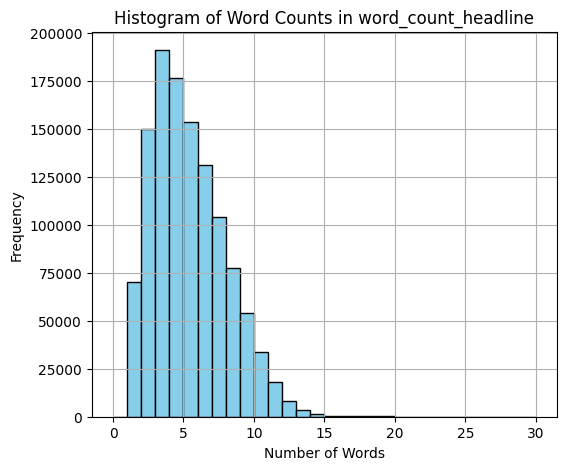

In [22]:
# Add new column for word count
review_df['word_count_headline'] = review_df['review_headline'].apply(count_words)

count_matplot(review_df, 'word_count_headline', 30)

Bin range: 1.00 - 215.58, Count: 868880
Bin range: 215.58 - 430.16, Count: 211140
Bin range: 430.16 - 644.74, Count: 51688
Bin range: 644.74 - 859.32, Count: 24628
Bin range: 859.32 - 1073.90, Count: 11979
Bin range: 1073.90 - 1288.48, Count: 3202
Bin range: 1288.48 - 1503.06, Count: 2002
Bin range: 1503.06 - 1717.64, Count: 514
Bin range: 1717.64 - 1932.22, Count: 339
Bin range: 1932.22 - 2146.80, Count: 158
Bin range: 2146.80 - 2361.38, Count: 79
Bin range: 2361.38 - 2575.96, Count: 69
Bin range: 2575.96 - 2790.54, Count: 54
Bin range: 2790.54 - 3005.12, Count: 27
Bin range: 3005.12 - 3219.70, Count: 21
Bin range: 3219.70 - 3434.28, Count: 18
Bin range: 3434.28 - 3648.86, Count: 4
Bin range: 3648.86 - 3863.44, Count: 11
Bin range: 3863.44 - 4078.02, Count: 9
Bin range: 4078.02 - 4292.60, Count: 8
Bin range: 4292.60 - 4507.18, Count: 2
Bin range: 4507.18 - 4721.76, Count: 4
Bin range: 4721.76 - 4936.34, Count: 5
Bin range: 4936.34 - 5150.92, Count: 4
Bin range: 5150.92 - 5365.50, Coun

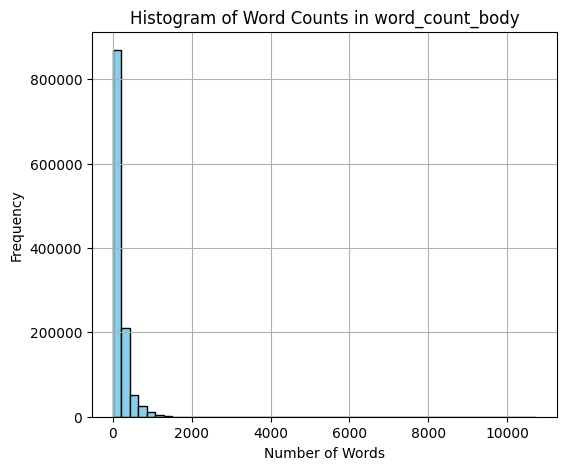

In [23]:
# Add new column for word count
review_df['word_count_body'] = review_df['review_body'].apply(count_words)

count_matplot(review_df, 'word_count_body', 50)

In [24]:
# Truncate review body to 1200
review_df = review_df[review_df.word_count_body <1200].reset_index()

# Print basic statistics for word counts
word_count_stats = review_df['word_count_body'].describe()
print(word_count_stats)

count    1.170204e+06
mean     1.771138e+02
std      1.708628e+02
min      1.000000e+00
25%      7.000000e+01
50%      1.220000e+02
75%      2.200000e+02
max      1.199000e+03
Name: word_count_body, dtype: float64


### **Tokenization & Cleaning**

In [25]:
# Define text processing functions
def convert_to_lowercase(text):
    return text.lower()

def remove_html_tags(text):
    return re.sub(r'<[^>]*>', '', text)

def remove_unwanted_chars(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    return text

def remove_urls(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

def remove_email_addresses(text):
    return re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text)

def remove_stopwords(text, stop_words):
    return ' '.join([word for word in word_tokenize(text) if word.lower() not in stop_words])

# Initialize WordNetLemmatizer outside of the function for better multiprocessing performance
lemmatizer = WordNetLemmatizer()

# Function to get WordNet POS tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return 'a'  # adjective
    elif tag.startswith('V'):
        return 'v'  # verb
    elif tag.startswith('N'):
        return 'n'  # noun
    elif tag.startswith('R'):
        return 'r'  # adverb
    else:
        return 'n'  # default to noun for lemmatization

# Function to lemmatize text with POS tagging
def lemmatize_with_pos_tagging(text):
    words = word_tokenize(text)
    pos_tags = pos_tag(words)
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tags]
    return ' '.join(lemmatized_words)

# Apply text processing in parallel using multiprocessing
def apply_parallel(df_column, func):
    with Pool(cpu_count()) as pool:
        return list(tqdm(pool.imap(func, df_column), total=len(df_column)))

# Function to optimize memory usage of a DataFrame
def optimize_memory_usage(df):
    for col in df.select_dtypes(include=['float']):
        df[col] = pd.to_numeric(df[col], downcast='float')
    for col in df.select_dtypes(include=['int']):
        df[col] = pd.to_numeric(df[col], downcast='integer')
    for col in df.select_dtypes(include=['object']):
        num_unique_values = len(df[col].unique())
        num_total_values = len(df[col])
        if num_unique_values / num_total_values < 0.5:
            df[col] = df[col].astype('category')
    return df

# Cleaned file path
cleaned_file_path = r"/content/drive/MyDrive/Colab Notebooks/GitHub/AmazonReview_UsefulnessRanker/data/review_df_cleaned.parquet"

if not os.path.exists(cleaned_file_path):
    # If the cleaned file does not exist, apply text processing steps
    print("Cleaned file not found. Processing the data...")

    # Convert to lowercase
    review_df['review_headline'] = review_df['review_headline'].apply(convert_to_lowercase)
    review_df['review_body'] = review_df['review_body'].apply(convert_to_lowercase)

    # Remove HTML tags
    review_df['review_headline'] = review_df['review_headline'].apply(remove_html_tags)
    review_df['review_body'] = review_df['review_body'].apply(remove_html_tags)

    # Remove unwanted characters
    review_df['review_headline'] = review_df['review_headline'].apply(remove_unwanted_chars)
    review_df['review_body'] = review_df['review_body'].apply(remove_unwanted_chars)

    # Remove URLs
    review_df['review_headline'] = review_df['review_headline'].apply(remove_urls)
    review_df['review_body'] = review_df['review_body'].apply(remove_urls)

    # Remove email addresses
    review_df['review_headline'] = review_df['review_headline'].apply(remove_email_addresses)
    review_df['review_body'] = review_df['review_body'].apply(remove_email_addresses)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    review_df['review_headline'] = apply_parallel(review_df['review_headline'], lambda x: remove_stopwords(x, stop_words))
    review_df['review_body'] = apply_parallel(review_df['review_body'], lambda x: remove_stopwords(x, stop_words))

    # Lemmatize with POS tagging
    review_df['review_headline'] = apply_parallel(review_df['review_headline'], lemmatize_with_pos_tagging)
    review_df['review_body'] = apply_parallel(review_df['review_body'], lemmatize_with_pos_tagging)

    # Optimize memory usage
    review_df = optimize_memory_usage(review_df)

    # Save cleaned data to file
    review_df.to_parquet(cleaned_file_path, index=False)
    print("Cleaned data saved to file.")
else:
    # If the cleaned file exists, load it
    review_df = pd.read_parquet(cleaned_file_path)
    print("Cleaned file loaded.")

    # Optimize memory usage
    review_df = optimize_memory_usage(review_df)

# Fixing missed nans, Drop rows with NaN values in log_helpfulness_ratio
review_df.dropna(subset=['log_helpfulness_ratio'], inplace=True)

# Display first few rows of the cleaned DataFrame to verify
review_df.head()

Cleaned file loaded.


,level_0,index,product_id,review_headline,review_body,log_helpfulness_ratio,word_count_headline,word_count_body
0,0,0,0385730586,book great learning novel,boook great one could learn teach imponrtance ...,0.510826,7,244
1,1,1,0811828964,fun fluff,look something stimulate brain isnt however lo...,0.693147,2,45
2,2,2,1844161560,isnt review,never read ita young relative idicated like so...,0.044452,4,19
3,3,3,0373836635,fine author agame,though honor chicago woman year victoria colby...,0.693147,5,266
4,4,4,0262181533,execellent cursor examination,review base cursory examination university pho...,0.000000,3,90


In [26]:
# Checking for missing values if unhandled before
review_df.isnull().sum()

level_0                  0
index                    0
product_id               0
review_headline          0
review_body              0
log_helpfulness_ratio    0
word_count_headline      0
word_count_body          0
dtype: int64

Bin range: 0.00 - 1.20, Count: 133813
Bin range: 1.20 - 2.40, Count: 343091
Bin range: 2.40 - 3.60, Count: 267067
Bin range: 3.60 - 4.80, Count: 211526
Bin range: 4.80 - 6.00, Count: 126284
Bin range: 6.00 - 7.20, Count: 81283
Bin range: 7.20 - 8.40, Count: 4796
Bin range: 8.40 - 9.60, Count: 1332
Bin range: 9.60 - 10.80, Count: 526
Bin range: 10.80 - 12.00, Count: 268
Bin range: 12.00 - 13.20, Count: 178
Bin range: 13.20 - 14.40, Count: 30
Bin range: 14.40 - 15.60, Count: 6
Bin range: 15.60 - 16.80, Count: 3
Bin range: 16.80 - 18.00, Count: 1


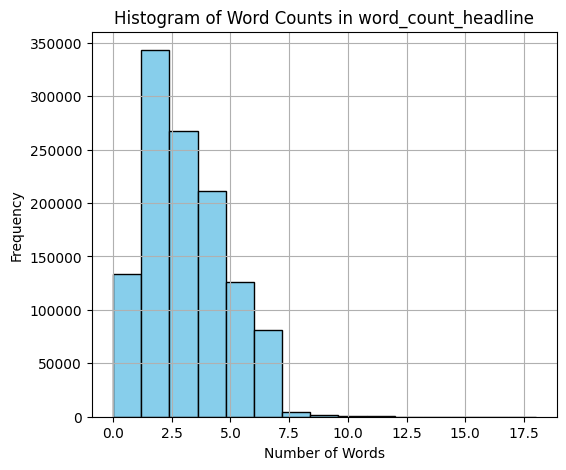

Bin range: 0.00 - 20.10, Count: 115755
Bin range: 20.10 - 40.20, Count: 242706
Bin range: 40.20 - 60.30, Count: 216862
Bin range: 60.30 - 80.40, Count: 151610
Bin range: 80.40 - 100.50, Count: 105923
Bin range: 100.50 - 120.60, Count: 75968
Bin range: 120.60 - 140.70, Count: 57519
Bin range: 140.70 - 160.80, Count: 44492
Bin range: 160.80 - 180.90, Count: 31228
Bin range: 180.90 - 201.00, Count: 21243
Bin range: 201.00 - 221.10, Count: 17395
Bin range: 221.10 - 241.20, Count: 13360
Bin range: 241.20 - 261.30, Count: 10829
Bin range: 261.30 - 281.40, Count: 9288
Bin range: 281.40 - 301.50, Count: 7641
Bin range: 301.50 - 321.60, Count: 6539
Bin range: 321.60 - 341.70, Count: 5806
Bin range: 341.70 - 361.80, Count: 5370
Bin range: 361.80 - 381.90, Count: 4749
Bin range: 381.90 - 402.00, Count: 4336
Bin range: 402.00 - 422.10, Count: 4031
Bin range: 422.10 - 442.20, Count: 3331
Bin range: 442.20 - 462.30, Count: 2972
Bin range: 462.30 - 482.40, Count: 2587
Bin range: 482.40 - 502.50, Coun

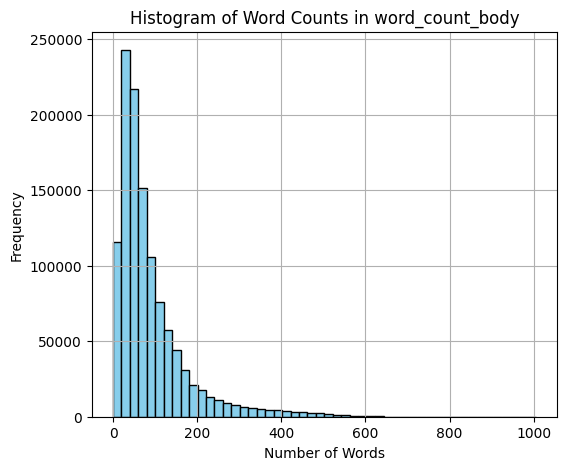

,count,mean,std,min,25%,50%,75%,max
level_0,1170204.0,635595.413446,369281.181632,0.0,315918.750000,632238.500000,953641.250000,1.281406e+06
index,1170204.0,638526.715927,370668.034886,0.0,317715.750000,635588.500000,957789.250000,1.286156e+06
log_helpfulness_ratio,1170204.0,0.537643,0.189463,0.0,0.445739,0.606136,0.693147,6.931472e-01
word_count_headline,1170204.0,3.131216,1.517023,0.0,2.000000,3.000000,4.000000,1.800000e+01
word_count_body,1170204.0,90.308806,88.510924,0.0,35.000000,62.000000,112.000000,1.005000e+03


In [27]:
# Add new column for review headline word count
review_df['word_count_headline'] = review_df['review_headline'].apply(count_words)

# Add new column for review body word count
review_df['word_count_body'] = review_df['review_body'].apply(count_words)

count_matplot(review_df, 'word_count_headline', 15)
count_matplot(review_df, 'word_count_body', 50)

# Looking at descriptive stats
review_df.describe().T

In [28]:
# Function to truncate and clean reviews
def truncate_and_clean(df, combined_cutoff, lower_cutoff):
    # Combine headline and body
    df['review_text'] = df['review_headline'] + ' ' + df['review_body']

    # Define the truncation function
    def truncate_text(text, cutoff):
        words = text.split()
        return ' '.join(words[:cutoff])

    # Apply truncation
    df['review_text'] = df['review_text'].apply(lambda x: truncate_text(x, combined_cutoff))

    # Filter out texts that are too short after cleaning
    df = df[df['review_text'].apply(lambda x: len(x.split()) >= lower_cutoff)]

    # Recalculate word counts after cleaning
    df['word_count_combined'] = df['review_text'].apply(lambda x: len(x.split()))

    return df

# File paths
final_file_path = r"/content/drive/MyDrive/Colab Notebooks/GitHub/AmazonReview_UsefulnessRanker/data/review_df_final2.parquet"

# Load the cleaned review data or process if not exists
if os.path.exists(final_file_path):
    review_df = pd.read_parquet(final_file_path)


else:
    # Apply truncation and cleaning
    review_df = truncate_and_clean(review_df, combined_cutoff=250, lower_cutoff=20)

    # Visualize the results
    count_matplot(review_df, 'word_count_combined', 50)

    # Select relevant columns
    review_df = review_df[['product_id', 'review_text', 'log_helpfulness_ratio']].copy()

    # Save review results to file
    review_df.to_parquet(final_file_path, index=False)

# Optimize memory usage
review_df = optimize_memory_usage(review_df)

# Reset the index
review_df.reset_index(drop=True, inplace=True)


### **Train Test Split**

In [29]:
X = review_df['review_text']
y = review_df['log_helpfulness_ratio'].rename({'log_helpfulness_ratio': 'target'})

# Initial split into train and validate
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Secondary split train into new train and test
# X_train_new, X_test, y_train_new, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [30]:
X_train = X_train.tolist()
X_val = X_val.tolist()

### **Embeddings**

In [31]:
# Function to encode texts using Sentence Transformer
def encode_texts(texts, model, batch_size=1024):
    embeddings = []
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():  # Disable gradient tracking
        for start in tqdm(range(0, len(texts), batch_size)):
            end = min(start + batch_size, len(texts))
            batch_embeddings = model.encode(
                texts[start:end],
                show_progress_bar=True,
                device='cuda',
                convert_to_tensor=True
            )
            embeddings.append(batch_embeddings)

    return torch.cat(embeddings).cpu().numpy()

# Function to fit TF-IDF vectorizer
def fit_vectorizer():
    vectorizer = TfidfVectorizer(max_features=5000)
    vectorizer.fit(X_train)

    # Save the vectorizer
    with open('tfidf_vectorizer.pkl', 'wb') as f:
        pickle.dump(vectorizer, f)

    return vectorizer

# Function to transform data in batches for TF-IDF
def transform_in_batches(data, vectorizer, batch_size=1024):
    embeddings = []
    for start in tqdm(range(0, len(data), batch_size), desc="Batches Processed"):
        end = min(start + batch_size, len(data))
        batch_embeddings = vectorizer.transform(data[start:end])
        embeddings.append(batch_embeddings)
        del batch_embeddings
        gc.collect()
    return vstack(embeddings)

In [32]:
# Embedding technique selection
use_tfidf = True

# Load model if using Sentence Transformer
if not use_tfidf:
    model = SentenceTransformer('paraphrase-mpnet-base-v2').to('cuda')

# Select embedding method
if use_tfidf:
    # Check if the vectorizer file exists
    if os.path.exists('tfidf_vectorizer.pkl'):
        with open('tfidf_vectorizer.pkl', 'rb') as f:
            vectorizer = pickle.load(f)
    else:
        vectorizer = fit_vectorizer()

    # Check if embeddings already exist
    if os.path.exists('train_embs_tfidf.npz') and os.path.exists('val_embs_tfidf.npz'):
        X_train_embs = scipy.sparse.load_npz('train_embs_tfidf.npz')
        X_val_embs = scipy.sparse.load_npz('val_embs_tfidf.npz')
    else:
        # Transform the training and validation sets in batches
        X_train_tfidf = transform_in_batches(X_train, vectorizer)
        scipy.sparse.save_npz('train_embs_tfidf.npz', X_train_tfidf)

        X_val_tfidf = transform_in_batches(X_val, vectorizer)
        scipy.sparse.save_npz('val_embs_tfidf.npz', X_val_tfidf)

else:
    # Generate embeddings for training and validation sets using Sentence Transformer
    X_train_embs = encode_texts(X_train, model)
    np.save('train_embs.npy', X_train_embs)

    X_val_embs = encode_texts(X_val, model)
    np.save('val_embs.npy', X_val_embs)

# Ensure embeddings have consistent shapes
print(f"Training embeddings shape: {X_train_embs.shape}")
print(f"Validation embeddings shape: {X_val_embs.shape}")

print(f"Training targets shape: {y_train.shape}")
print(f"Validation targets shape: {y_val.shape}")

Training embeddings shape: (872200, 5000)
Validation embeddings shape: (218051, 5000)
Training targets shape: (872200,)
Validation targets shape: (218051,)


**Observation:**
- Tried implementing the sentence transformer with memory issues, optimising the code of TF-IDF to avoid the memory issues and save results to disk
- Will be using the sparce matrices after the embedding to perform the modelling. Using appropriate models which can handle sparce matrices

## Modelling

### **Ridge with CV**

In [37]:
# Define the path for the model and CV scores
ridge_model_path = 'ridge_model.pkl'
ridge_cv_scores_path = 'ridge_cv_scores.pkl'

# Check if the model exists
if os.path.exists(ridge_model_path):
    # Load the model
    ridge_model = joblib.load(ridge_model_path)
    # Load CV scores
    ridge_cv_scores = joblib.load(ridge_cv_scores_path)
else:
    # Using Ridge
    ridge_model = Ridge(alpha=1.0, random_state=seed)

    # Fitting the model on train
    ridge_model.fit(X_train_embs, y_train)

    # Save the model and CV scores
    joblib.dump(ridge_model, ridge_model_path)

    # Create a KFold object with a seed
    kf = KFold(n_splits=5, shuffle=True, random_state=seed)

    # Perform cross-validation
    ridge_cv_scores = cross_val_score(ridge_model, X_train_embs, y_train, cv=kf, scoring='neg_root_mean_squared_error')
    joblib.dump(ridge_cv_scores, ridge_cv_scores_path)

# Convert negative RMSE to positive
ridge_cv_rmse = -ridge_cv_scores

print(f"Ridge Cross-Validated RMSE: {ridge_cv_rmse}")
print(f"Ridge Mean RMSE: {ridge_cv_rmse.mean()}")
print(f"Ridge Standard Deviation of RMSE: {ridge_cv_rmse.std()}")

# Evaluation on unseen data
ridge_predictions = ridge_model.predict(X_val_embs)
print(f"Ridge Regression Validation RMSE: {mean_squared_error(y_val, ridge_predictions, squared=False)}")

Ridge Cross-Validated RMSE: [0.16665174 0.16680732 0.16631517 0.16604248 0.16672352]
Ridge Mean RMSE: 0.1665080462626553
Ridge Standard Deviation of RMSE: 0.0002865616146020323
Ridge Regression Validation RMSE: 0.16618775432038585


### **XGB with CV**

In [38]:
# Define file paths
xgb_model_path = 'xgb_model.pkl'
xgb_cv_scores_path = 'xgb_cv_scores.pkl'

# Check if the model exists, if not, fit and save the model
if os.path.exists(xgb_model_path):
    xgb_model = joblib.load(xgb_model_path)
else:
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=seed)
    xgb_model.fit(X_train_embs, y_train)
    joblib.dump(xgb_model, xgb_model_path)

# Check if CV scores exist, if not, perform cross-validation and save the scores
if os.path.exists(xgb_cv_scores_path):
    xgb_cv_scores = joblib.load(xgb_cv_scores_path)
else:
    # Create a KFold object with a seed
    kf = KFold(n_splits=5, shuffle=True, random_state=seed)
    xgb_cv_scores = cross_val_score(xgb_model, X_train_embs, y_train, cv=kf, scoring='neg_root_mean_squared_error')
    joblib.dump(xgb_cv_scores, xgb_cv_scores_path)

# Convert negative RMSE to positive
xgb_cv_rmse = -xgb_cv_scores

print(f"XGB Cross-Validated RMSE: {xgb_cv_rmse}")
print(f"XGB Mean RMSE: {xgb_cv_rmse.mean()}")
print(f"XGB Standard Deviation of RMSE: {xgb_cv_rmse.std()}")

# Evaluation on unseen data
xgb_predictions = xgb_model.predict(X_val_embs)
print(f"XGBoost Validation RMSE: {mean_squared_error(y_val, xgb_predictions, squared=False)}")


XGB Cross-Validated RMSE: [0.16886376 0.16896036 0.16854933 0.16822688 0.16884634]
XGB Mean RMSE: 0.1686893343925476
XGB Standard Deviation of RMSE: 0.00026907005808554803
XGBoost Validation RMSE: 0.16841229796409607


### **LightGBM with CV**

In [39]:
# Define the path for the model and CV scores
lgb_model_path = 'lgb_model.pkl'
lgb_cv_scores_path = 'lgb_cv_scores.pkl'

# Check if the model exists
if os.path.exists(lgb_model_path):
    # Load the model
    lgb_model = joblib.load(lgb_model_path)
    # Load CV scores
    lgb_cv_scores = joblib.load(lgb_cv_scores_path)
else:
    # Using LightGBM
    lgb_model = lgb.LGBMRegressor(random_state=seed)

    # Fitting the model on train
    lgb_model.fit(X_train_embs, y_train)

    # Save the model
    joblib.dump(lgb_model, lgb_model_path)

    # Create a KFold object with a seed
    kf = KFold(n_splits=5, shuffle=True, random_state=seed)

    # Perform 5-fold cross-validation
    lgb_cv_scores = cross_val_score(lgb_model, X_train_embs, y_train, cv=kf, scoring='neg_root_mean_squared_error')

    # Save CV scores
    joblib.dump(lgb_cv_scores, lgb_cv_scores_path)

# Convert negative RMSE to positive
lgb_cv_rmse = -lgb_cv_scores

print(f"LightGBM Cross-Validated RMSE: {lgb_cv_rmse}")
print(f"LightGBM Mean RMSE: {lgb_cv_rmse.mean()}")
print(f"LightGBM Standard Deviation of RMSE: {lgb_cv_rmse.std()}")

# Evaluation on unseen data
lgb_predictions = lgb_model.predict(X_val_embs)
print(f"LightGBM RMSE: {mean_squared_error(y_val, lgb_predictions, squared=False)}")


LightGBM Cross-Validated RMSE: [0.16812232 0.16826833 0.1677639  0.16753733 0.16818216]
LightGBM Mean RMSE: 0.16797480667898954
LightGBM Standard Deviation of RMSE: 0.0002781307689261952
LightGBM RMSE: 0.16790091958366032


In [40]:
# Function to calculate Adjusted R²
def adjusted_r2(r2, n, p):
    return 1 - ((1 - r2) * (n - 1) / (n - p - 1))

# Number of observations and predictors
n = X_val_embs.shape[0]
p = X_train_embs.shape[1]

# Calculate metrics
metrics = {
    'Ridge': {
        'R²': r2_score(y_val, ridge_predictions),
        'Adjusted R²': adjusted_r2(r2_score(y_val, ridge_predictions), n, p),
        'MAE': mean_absolute_error(y_val, ridge_predictions),
        'Explained Variance': explained_variance_score(y_val, ridge_predictions),
        'RMSE': mean_squared_error(y_val, ridge_predictions, squared=False),
        'Cross-Validated RMSE': ridge_cv_rmse.mean(),
        'Standard Deviation of RMSE': ridge_cv_rmse.std()
    },
    'XGBoost': {
        'R²': r2_score(y_val, xgb_predictions),
        'Adjusted R²': adjusted_r2(r2_score(y_val, xgb_predictions), n, p),
        'MAE': mean_absolute_error(y_val, xgb_predictions),
        'Explained Variance': explained_variance_score(y_val, xgb_predictions),
        'RMSE': mean_squared_error(y_val, xgb_predictions, squared=False),
        'Cross-Validated RMSE': xgb_cv_rmse.mean(),
        'Standard Deviation of RMSE': xgb_cv_rmse.std()
    },
    'LightGBM': {
        'R²': r2_score(y_val, lgb_predictions),
        'Adjusted R²': adjusted_r2(r2_score(y_val, lgb_predictions), n, p),
        'MAE': mean_absolute_error(y_val, lgb_predictions),
        'Explained Variance': explained_variance_score(y_val, lgb_predictions),
        'RMSE': mean_squared_error(y_val, lgb_predictions, squared=False),
        'Cross-Validated RMSE': lgb_cv_rmse.mean(),
        'Standard Deviation of RMSE': lgb_cv_rmse.std()
    }
}

# Print metrics
for model_name, model_metrics in metrics.items():
    print(f"\n{model_name} Metrics:")
    for metric_name, metric_value in model_metrics.items():
        print(f"{metric_name}: {metric_value}")



Ridge Metrics:
R²: 0.1510990398413825
Adjusted R²: 0.13117646391651472
MAE: 0.12403321298726072
Explained Variance: 0.1511010900273857
RMSE: 0.16618775432038585
Cross-Validated RMSE: 0.1665080462626553
Standard Deviation of RMSE: 0.0002865616146020323

XGBoost Metrics:
R²: 0.12822051962831826
Adjusted R²: 0.1077610152778915
MAE: 0.12683077156543732
Explained Variance: 0.12822359800338745
RMSE: 0.16841229796409607
Cross-Validated RMSE: 0.1686893343925476
Standard Deviation of RMSE: 0.00026907005808554803

LightGBM Metrics:
R²: 0.1335068461172476
Adjusted R²: 0.11317140481514132
MAE: 0.12635387815223087
Explained Variance: 0.13350850079815701
RMSE: 0.16790091958366032
Cross-Validated RMSE: 0.16797480667898954
Standard Deviation of RMSE: 0.0002781307689261952


**Observation:**
- Ridge Regression appears to be the best model overall based on these metrics. It has the highest R², Adjusted R², and Explained Variance, the lowest MAE, Validation RMSE, and Cross-Validated RMSE, and performs consistently well.

- LightGBM is a close second, particularly if you value slightly more flexibility and potential future tuning of hyperparameters.

- XGBoost performs the worst in this comparison but is still a viable option if its specific strengths or other considerations are relevant to this use case.

### **Feature Importance**

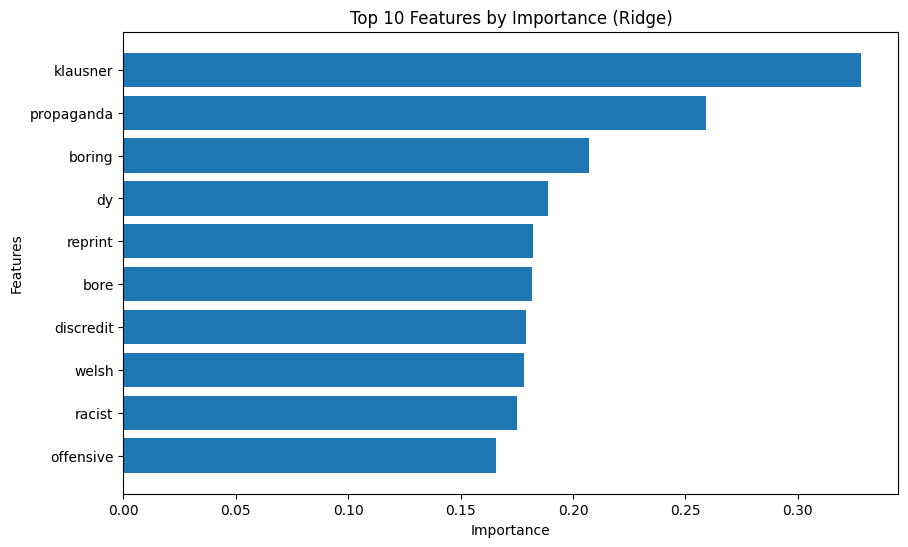

klausner: 0.3283420252968458
propaganda: 0.25924339640828126
boring: 0.20701752743903434
dy: 0.18908672577383576
reprint: 0.18222270393073217
bore: 0.18183396389624173
discredit: 0.17924899455699478
welsh: 0.17832905728941909
racist: 0.17523068967459102
offensive: 0.1656638192375904


In [43]:
# Calculate the importance of each feature
importance = np.abs(ridge_model.coef_)
feature_importance = importance / np.sum(importance)

# Get the feature names from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Sort the features by importance
sorted_indices = np.argsort(importance)[::-1]
top_features = feature_names[sorted_indices]
top_importance = importance[sorted_indices]

# Plot the top 10 features by importance
plt.figure(figsize=(10, 6))
plt.barh(top_features[:10], top_importance[:10])
plt.title('Top 10 Features by Importance (Ridge)')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

# Print the top features and their importance scores
top_n = 10  # Number of top features to print
top_features_with_scores = [(feature_names[i], importance[i]) for i in sorted_indices[:top_n]]
for feature, score in top_features_with_scores:
    print(f"{feature}: {score}")

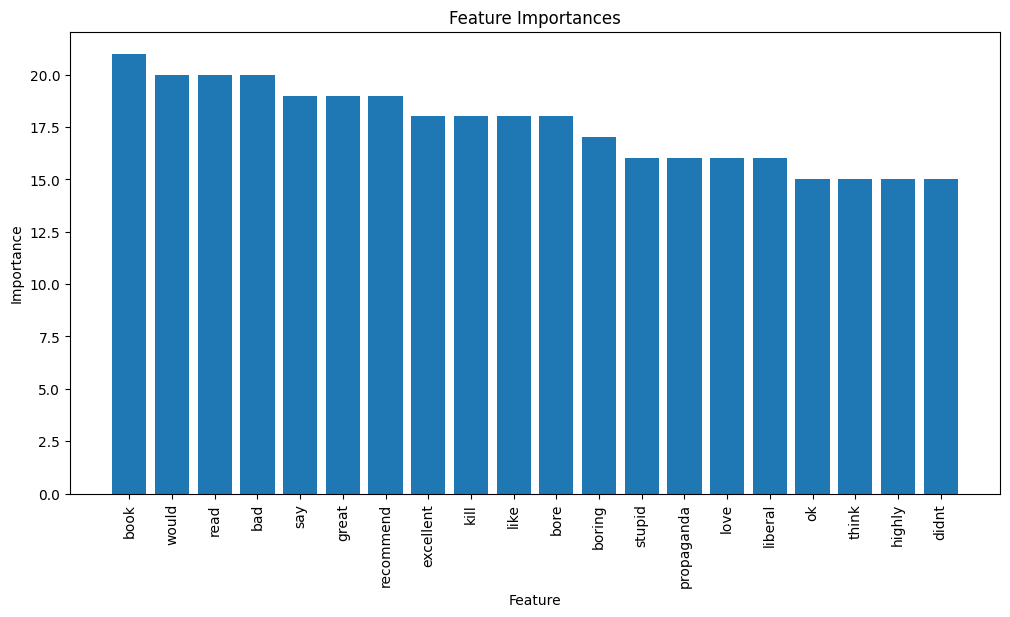

book: 21
would: 20
read: 20
bad: 20
say: 19
great: 19
recommend: 19
excellent: 18
kill: 18
like: 18
bore: 18
boring: 17
stupid: 16
propaganda: 16
love: 16
liberal: 16
ok: 15
think: 15
highly: 15
didnt: 15


In [44]:
# Extract feature importance
importance = lgb_model.feature_importances_
feature_names = vectorizer.get_feature_names_out()

# Sort feature importances in descending order
indices = np.argsort(importance)[::-1]
top_n = 20  # Number of top features to display

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.title('Feature Importances')
plt.bar(range(top_n), importance[indices[:top_n]], align='center')
plt.xticks(range(top_n), [feature_names[i] for i in indices[:top_n]], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

# Print top features and their importance scores
top_features = [(feature_names[i], importance[i]) for i in indices[:top_n]]
for feature, score in top_features:
    print(f"{feature}: {score}")

In [45]:
# matches = book_df[book_df['review_body'].str.contains('kill', case=False, na=False)]

# pd.set_option('display.max_colwidth', None)  # Set to None to display full text

# Display the matched reviews
# matches['review_body']

## Recommendating top useful Reviews

In [46]:
# Create a DataFrame for predicted usefulness
predicted_usefulness_df = pd.DataFrame({
    'predicted_usefulness': ridge_predictions,
    'review_text': X_val  # Add the review text to map
})

# Merge to get product_id
predicted_usefulness_df = predicted_usefulness_df.merge(
    review_df[['product_id', 'review_text']],
    on='review_text',
    how='left'
)

# Sort reviews by predicted usefulness within each product
ranked_reviews = predicted_usefulness_df.sort_values(by=['product_id', 'predicted_usefulness'], ascending=[True, False])

# Optionally, get the top N reviews per product
top_reviews_per_product = ranked_reviews.groupby('product_id').head(5)  # Get top 5 reviews

In [47]:
top_reviews_per_product

,predicted_usefulness,review_text,product_id
118220,0.620492,impactful conversation god book single extraor...,0000000078
93293,0.504602,joss ackland end joseph conrad begin already l...,0001052020
41338,0.628951,still recite recently visit parent search book...,000171287X
78291,0.606024,one snowy night excellent first book nick butt...,0001954792
193692,0.624238,classic childrens story book arrive weve alrea...,0001983679
...,...,...,...
152945,0.600597,husband guide happy marriage read feel good bo...,B000HXDKHK
154245,0.643818,eleven great river come surprise discover none...,B000M8RPU8
206550,0.570481,handle care say dangerous thought measure trut...,B000PC6XBS
10551,0.646615,autism family rachel meet jack bar student col...,B001PO6A18


## Conclusion

### Conclusion

In this analysis, we successfully identified the most effective model for predicting the usefulness of reviews using machine learning techniques. Our findings can be summarized as follows:

- **Best Model Selection**: After evaluating multiple models, **Ridge Regression** emerged as the best performer with the following metrics:
  - **Mean RMSE**: 0.1665
  - **Standard Deviation of RMSE**: 0.00029
  - **R²**: 0.1511
  - **Adjusted R²**: 0.1312
  Its ability to generalize well with the dataset makes it a reliable choice for this task.

- **Feature Importance Insights**:
  - Feature importance scores from **Ridge Regression** highlighted several critical keywords impacting usefulness, such as:
    - **"propaganda" (0.259)** and **"boring" (0.207)** were identified as highly significant negative indicators.
    - **"excellent" (0.122)** and **"kill" (0.111)** emerged as strong positive indicators, suggesting that reviews containing these terms are perceived as more useful.
  - In contrast, **LightGBM** provided a consistent ranking of features, with a similar emphasis on keywords like **"book" (21)** and **"bad" (20)**, indicating their relevance across various contexts.

- **Embedding Techniques**: Embedding techniques choices are as below:
  - **TF-IDF**: Efficient for sparse data representation and capturing word importance.
  - **Sentence Transformers**: More context-aware embeddings that capture semantic meaning, providing richer representations of review texts.
  Exploring and comparing these techniques led to enhanced model performance.

- **Usefulness Ranking**: By utilizing the predicted log usefulness ratios, we can effectively rank reviews for each product. This approach empowers users to quickly identify the top N most useful reviews, enhancing their decision-making process when selecting products.

### Application of the Model

This model can be implemented in various ways:
- **Web Applications**: Integrate the model into e-commerce platforms to display the most useful reviews prominently, improving user experience and trust.
- **Data Analysis**: Utilize the insights gained from feature importance to refine marketing strategies and understand customer sentiment better.
- **Further Development**: Future enhancements may involve exploring additional embedding techniques, such as using **BERT or GPT** for even richer representations, or conducting more extensive hyperparameter tuning to further improve prediction accuracy.

Overall, this analysis not only provides a robust methodology for evaluating review usefulness but also sets a foundation for actionable insights in product marketing and customer engagement.
